In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv('NYCTaxiFares.csv')

### Data Preprocessing and Feature Engineering

In [4]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [5]:
df['fare_amount'].describe()

count    120000.000000
mean         10.040326
std           7.500134
min           2.500000
25%           5.700000
50%           7.700000
75%          11.300000
max          49.900000
Name: fare_amount, dtype: float64

### Obtaining Distance from the GPS coordinates

It is observed that the distance would be a better metric than just feeding the latitude and longitude to the model.

We use the Haversine formula to measure teh distance between two areas based on their GPS coordinates

In [6]:
def haversine_distance(df, lat1, long1, lat2, long2):
    """
    Calculates the haversine distance between 2 sets of GPS coordinates in df
    """
    r = 6371  # average radius of Earth in kilometers
       
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers

    return d

In [7]:
df.columns

Index(['pickup_datetime', 'fare_amount', 'fare_class', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count'],
      dtype='object')

In [8]:
df['dist_km'] = haversine_distance(df,'pickup_latitude',
       'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')

In [9]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   pickup_datetime    120000 non-null  object 
 1   fare_amount        120000 non-null  float64
 2   fare_class         120000 non-null  int64  
 3   pickup_longitude   120000 non-null  float64
 4   pickup_latitude    120000 non-null  float64
 5   dropoff_longitude  120000 non-null  float64
 6   dropoff_latitude   120000 non-null  float64
 7   passenger_count    120000 non-null  int64  
 8   dist_km            120000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 8.2+ MB


pd.to_datetime : used to convert string datetime to pandas datetime object

In [11]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   pickup_datetime    120000 non-null  datetime64[ns, UTC]
 1   fare_amount        120000 non-null  float64            
 2   fare_class         120000 non-null  int64              
 3   pickup_longitude   120000 non-null  float64            
 4   pickup_latitude    120000 non-null  float64            
 5   dropoff_longitude  120000 non-null  float64            
 6   dropoff_latitude   120000 non-null  float64            
 7   passenger_count    120000 non-null  int64              
 8   dist_km            120000 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(6), int64(2)
memory usage: 8.2 MB


In [13]:
my_time = df['pickup_datetime'][0]

### Processing the timestamps

Accounting for difference in timezone

In [14]:
df['EDTDate'] = df['pickup_datetime'] - pd.Timedelta(hours=4)

Timedelta represents a duration of time

In [15]:
df['Hour'] = df['EDTDate'].dt.hour

.dt is the accessor object for datetime 

In [16]:
df['AMorPM'] = np.where(df['Hour']<12,'am','pm')

In [17]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTDate,Hour,AMorPM
0,2010-04-19 08:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56+00:00,4,am
1,2010-04-17 15:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53+00:00,11,am
2,2010-04-17 11:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26+00:00,7,am
3,2010-04-11 21:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03+00:00,17,pm
4,2010-04-17 02:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01+00:00,22,pm


In [18]:
df['Weekday'] = df['EDTDate'].dt.strftime("%a")

strftime - used to convert dates in a given series object to the specified format. In this case we are extracting the days of the week

In [19]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTDate,Hour,AMorPM,Weekday
0,2010-04-19 08:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56+00:00,4,am,Mon
1,2010-04-17 15:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53+00:00,11,am,Sat
2,2010-04-17 11:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26+00:00,7,am,Sat
3,2010-04-11 21:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03+00:00,17,pm,Sun
4,2010-04-17 02:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01+00:00,22,pm,Fri


### Dealing with the newly created categorical variables

In [20]:
cat_cols = ['Hour','AMorPM','Weekday']
cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'dist_km']

In [21]:
y_col = ['fare_amount']

In [22]:
df.dtypes

pickup_datetime      datetime64[ns, UTC]
fare_amount                      float64
fare_class                         int64
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
dist_km                          float64
EDTDate              datetime64[ns, UTC]
Hour                               int64
AMorPM                            object
Weekday                           object
dtype: object

Converting from numerical to categorical columns

In [23]:
for cat in cat_cols:
    df[cat] = df[cat].astype('category')

Doubt : can we replace encoding(one-hot or binary by this??)

In [24]:
df['Hour'].head()

0     4
1    11
2     7
3    17
4    22
Name: Hour, dtype: category
Categories (24, int64): [0, 1, 2, 3, ..., 20, 21, 22, 23]

In [25]:
df['AMorPM'].head()

0    am
1    am
2    am
3    pm
4    pm
Name: AMorPM, dtype: category
Categories (2, object): ['am', 'pm']

In [26]:
df['Weekday'].head()

0    Mon
1    Sat
2    Sat
3    Sun
4    Fri
Name: Weekday, dtype: category
Categories (7, object): ['Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed']

#### Obtaining the categories within the column

In [27]:
df['AMorPM'].cat.categories

Index(['am', 'pm'], dtype='object')

#### Corresponding category codes

In [28]:
df['AMorPM'].cat.codes

0         0
1         0
2         0
3         1
4         1
         ..
119995    0
119996    0
119997    1
119998    0
119999    1
Length: 120000, dtype: int8

Converting them to numpy arrays

In [29]:
hr = df['Hour'].cat.codes.values
ampm = df['AMorPM'].cat.codes.values
wkday = df['Weekday'].cat.codes.values

In [30]:
cats = np.stack([hr,ampm,wkday],axis=1)

In [31]:
cats

array([[ 4,  0,  1],
       [11,  0,  2],
       [ 7,  0,  2],
       ...,
       [14,  1,  3],
       [ 4,  0,  5],
       [12,  1,  2]], dtype=int8)

All these operations can be alternatively done via list comprehension

In [32]:
cats = np.stack([df[cols].astype('category').cat.codes.values for cols in cat_cols],axis=1)

In [33]:
cats

array([[ 4,  0,  1],
       [11,  0,  2],
       [ 7,  0,  2],
       ...,
       [14,  1,  3],
       [ 4,  0,  5],
       [12,  1,  2]], dtype=int8)

Converting numpy array to tensor

In [34]:
cats = torch.tensor(cats,dtype=torch.int64)

In [35]:
conts = np.stack([df[cols].values for cols in cont_cols],axis=1)

In [36]:
conts

array([[ 40.730521  , -73.992365  ,  40.744746  , -73.975499  ,
          1.        ,   2.12631159],
       [ 40.740558  , -73.990078  ,  40.744114  , -73.974232  ,
          1.        ,   1.39230687],
       [ 40.751118  , -73.994149  ,  40.766235  , -73.960064  ,
          2.        ,   3.32676344],
       ...,
       [ 40.749772  , -73.988574  ,  40.707799  , -74.011541  ,
          3.        ,   5.05252282],
       [ 40.724529  , -74.004449  ,  40.730765  , -73.992697  ,
          1.        ,   1.20892296],
       [ 40.77192   , -73.955415  ,  40.763015  , -73.967623  ,
          3.        ,   1.42739869]])

In [37]:
conts = torch.tensor(conts, dtype= torch.float)

Use reshape(-1,1) only if the data is not being read as a column vector

In [38]:
y = torch.tensor(df[y_col].values, dtype=torch.float)

In [39]:
y

tensor([[ 6.5000],
        [ 6.9000],
        [10.1000],
        ...,
        [12.5000],
        [ 4.9000],
        [ 5.3000]])

In [40]:
cats.shape

torch.Size([120000, 3])

In [41]:
conts.shape

torch.Size([120000, 6])

In [42]:
y.shape

torch.Size([120000, 1])

Adding an embedding layer is analogous to one-hot-encoding the categorical features

Obtaining the number of categories in under each categorical feature/column

In [43]:
cat_szs = [len(df[col].cat.categories) for col in cat_cols]

In [44]:
cat_szs

[24, 2, 7]

Next, we obtain the embedding sizes

In [45]:
emb_szs = [(size,min(50,(size+1)//2)) for size in cat_szs]

In [46]:
emb_szs

[(24, 12), (2, 1), (7, 4)]

Setting up a tabular model

In [51]:
catz = cats[:2]

In [48]:
catz

tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2],
        [17,  1,  3]])

In [52]:
selfembeds = nn.ModuleList([nn.Embedding(ni,nf)  for ni,nf in emb_szs])

In [53]:
selfembeds

ModuleList(
  (0): Embedding(24, 12)
  (1): Embedding(2, 1)
  (2): Embedding(7, 4)
)

We then pass our categorical data into the embedding layer

In [54]:
embeddingz = []

for i,e in enumerate(selfembeds):
    embeddingz.append(e(catz[:,i]))

We obtain tensors of the size determined in emb_szs

In [55]:
embeddingz

[tensor([[-1.4253, -0.4033, -1.3395, -1.4749,  0.2063, -0.5138, -0.5106,  2.0497,
          -0.5628,  2.5062,  0.4950, -1.7655],
         [ 0.5515, -0.6068, -0.2678,  2.1573, -0.8085, -2.2486, -0.9081, -0.4660,
           2.1517, -0.2704,  1.8073,  0.6879]], grad_fn=<EmbeddingBackward0>),
 tensor([[-0.3002],
         [-0.3002]], grad_fn=<EmbeddingBackward0>),
 tensor([[-1.1720, -1.1300, -0.3910, -0.2341],
         [-1.6676, -0.6360, -1.3517,  1.1798]], grad_fn=<EmbeddingBackward0>)]

In [56]:
z = torch.cat(embeddingz,1)

In [57]:
z

tensor([[-1.4253, -0.4033, -1.3395, -1.4749,  0.2063, -0.5138, -0.5106,  2.0497,
         -0.5628,  2.5062,  0.4950, -1.7655, -0.3002, -1.1720, -1.1300, -0.3910,
         -0.2341],
        [ 0.5515, -0.6068, -0.2678,  2.1573, -0.8085, -2.2486, -0.9081, -0.4660,
          2.1517, -0.2704,  1.8073,  0.6879, -0.3002, -1.6676, -0.6360, -1.3517,
          1.1798]], grad_fn=<CatBackward0>)

Randomly turns off the specified proportion of neurons and hence prevents overfitting

In [58]:
selfembddrop = nn.Dropout(0.4)

In [59]:
z = selfembddrop(z)

In [60]:
z

tensor([[-2.3755, -0.0000, -2.2325, -0.0000,  0.3438, -0.0000, -0.8511,  0.0000,
         -0.9380,  0.0000,  0.8250, -2.9425, -0.5003, -0.0000, -1.8833, -0.0000,
         -0.0000],
        [ 0.9192, -1.0113, -0.4464,  3.5955, -1.3475, -3.7477, -1.5134, -0.7767,
          0.0000, -0.4507,  0.0000,  1.1465, -0.0000, -2.7793, -1.0600, -2.2528,
          1.9663]], grad_fn=<MulBackward0>)

In [83]:
class TabularModel(nn.Module):
    def __init__(self,emb_szs,n_cont,out_sz,layers,p = 0.5):
        super().__init__()

        #This snippet creates embedding layers for the categorical variables
        self.embeds = nn.ModuleList([nn.Embedding(ni,nf) for ni,nf in emb_szs]) 
        self.emb_drop = nn.Dropout(p) #to avoid overfitting
        self.bn_cont = nn.BatchNorm1d(n_cont) #Initialise the batch normalisation object for the continuous classes

        layerlist = []
        n_emb = sum([nf for ni,nf in emb_szs])
        n_in = n_emb + n_cont #This is the total number of input features

        #layers is a list with dimensions of the hidden layer. So let's say in this case layers =[100,50]
        #The following for loop will churn out layers and will go on storing them in the layers list
        for i in layers: 
            layerlist.append(nn.Linear(n_in,i))
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        
        layerlist.append(nn.Linear(layers[-1],out_sz)) #This will create the output layer
        #print(layerlist)

        #The layers that we need are present in the layerlist. They are executed sequentially
        self.layers = nn.Sequential(*layerlist)

    def forward(self,x_cat,x_cont):
        embeddings = []

        #Assigning values to the one hot encodings
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
    
        #Concatinating the batch normalized continuous variables with the embedded categorical variables
        x = torch.cat(embeddings,1)
        x = self.emb_drop(x)

        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x,x_cont],1)
        x = self.layers(x)

        return x
        

In [84]:
torch.manual_seed(33)
model = TabularModel(emb_szs,conts.shape[1],1,[200,100], p = 0.4)

In [85]:
model.eval()

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

Loss function and optimizer

In [102]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)


In [103]:
batch_size  = 60000
test_size = int(batch_size*0.2)

In [104]:
cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]
cont_train = conts[:batch_size-test_size]
cont_test = conts[batch_size-test_size:batch_size]

In [105]:
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

In [106]:
len(cat_train)

48000

In [107]:
len(cont_train)

48000

Training the model

In [98]:
import time
start_time = time.time()

epochs = 100

losses = []
for i in range(epochs):
    i += 1
    y_pred = model(cat_train, cont_train)
    loss = torch.sqrt(criterion(y_pred,y_train))
    losses.append(loss.item())

    if i%10 == 0:
        print(f'epoch {i} loss is {loss.item()}')

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

duration = time.time() - start_time
print(f'Training duration is {duration/60} minutes')

epoch 10 loss is 3.268282651901245
epoch 20 loss is 3.2666409015655518
epoch 30 loss is 3.2650070190429688
epoch 40 loss is 3.263953685760498
epoch 50 loss is 3.2630441188812256
epoch 60 loss is 3.2965500354766846
epoch 70 loss is 3.2877185344696045
epoch 80 loss is 3.2641377449035645
epoch 90 loss is 3.264258861541748
epoch 100 loss is 3.2597970962524414
Training duration is 1.051534859339396 minutes


Text(0, 0.5, 'loss')

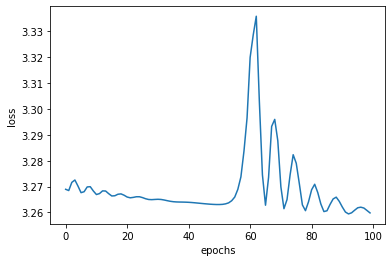

In [100]:
plt.plot(range(epochs),losses)
plt.xlabel('epochs')
plt.ylabel('loss')

In [108]:
with torch.no_grad():
    y_val = model(cat_test,cont_test)
    loss = torch.sqrt(criterion(y_val,y_test))

In [109]:
loss

tensor(3.1586)

In [116]:

for i in range(10):
    diff = np.abs(y_val[i].item() - y_test[i].item())
    print(f'{i}.) Predicted value:{y_val[i]} Actual value:{y_test[i]} Difference : {diff}')

0.) Predicted value:tensor([3.8771]) Actual value:tensor([2.9000]) Difference : 0.977123498916626
1.) Predicted value:tensor([19.8984]) Actual value:tensor([5.7000]) Difference : 14.198355674743652
2.) Predicted value:tensor([7.7683]) Actual value:tensor([7.7000]) Difference : 0.06834697723388672
3.) Predicted value:tensor([13.7897]) Actual value:tensor([12.5000]) Difference : 1.289724349975586
4.) Predicted value:tensor([4.9041]) Actual value:tensor([4.1000]) Difference : 0.8041234016418457
5.) Predicted value:tensor([5.1490]) Actual value:tensor([5.3000]) Difference : 0.1510009765625
6.) Predicted value:tensor([4.9911]) Actual value:tensor([3.7000]) Difference : 1.2910830974578857
7.) Predicted value:tensor([20.0754]) Actual value:tensor([14.5000]) Difference : 5.575431823730469
8.) Predicted value:tensor([5.0288]) Actual value:tensor([5.7000]) Difference : 0.6712074279785156
9.) Predicted value:tensor([12.1885]) Actual value:tensor([10.1000]) Difference : 2.0884580612182617


Saving the model

In [117]:
torch.save(model.state_dict(),'TaxiModel.pt')